In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from tqdm import tqdm
import pickle

import swimAD2 as ad2       
import time
import dwfconstants as dwfc

ad2.disconnect()            
zoroku = ad2.connect(0)      #彼は老人
alice = ad2.connect(1)      #彼女はアンドロイド

In [52]:
# Test by first bringing backwards. 
# If fails, test forwards. 

def find_times(Ch2,ch2):
    backward,forward = [],[]
    for i in range(1,100):
        score = abs((Ch2[i:]-ch2[:-i])/(Ch2[i:]+ch2[:-i]))
        backward.append(np.mean(score))

        score = abs((Ch2[:-i]-ch2[i:])/(Ch2[:-i]+ch2[i:]))
        forward.append(np.mean(score))

    score_back = np.min(backward)
    score_forw = np.min(forward)

    if score_back > score_forw:
        print(np.argmin(forward))
        i = np.argmin(forward)
        direction = "f"
    else: 
        print(np.argmin(backward))
        i = np.argmin(backward) 
        direction = "b"
    return i, direction

def sync_series(t0,ch1,Ch2,ch2,ch3):
    i,direction = find_times(Ch2,ch2)
    if direction=="b":
        return t0[:-i],ch1[:-i],ch2[i:],ch3[i:]
    else: 
        return t0[i:],ch1[i:],ch2[:-i],ch3[:-i]
    
def sampling(time):
    hertz = 100e6
    size = time*hertz 
    if size <= 8192:
        return size,hertz
    else: 
        size = 8192
        hertz = size/time
        return size,hertz

In [ ]:
size,rate = sampling(5)
    
rng = 5
for swim in [zoroku,alice]:
    ad2.config_oscilloscope(swim,
        range0=rng,
        range1=rng,
        sample_rate = rate,
        sample_size= size,
        )

ad2.config_wavegen(zoroku, 
        frequency=100,
        amplitude=5,
        signal_shape=dwfc.funcSine
        )

ad2.start_wavegen(zoroku,channel=0)
time.sleep(0.1)

t0,ch1,Ch2 = ad2.measure_oscilloscope(zoroku)
t1,ch2,ch3 = ad2.measure_oscilloscope(alice)

ad2.stop_wavegen(zoroku,channel=0)
ad2.reset_wavegen(zoroku,channel=0)

meas = sync_series(t0,ch1,Ch2,ch2,ch3)

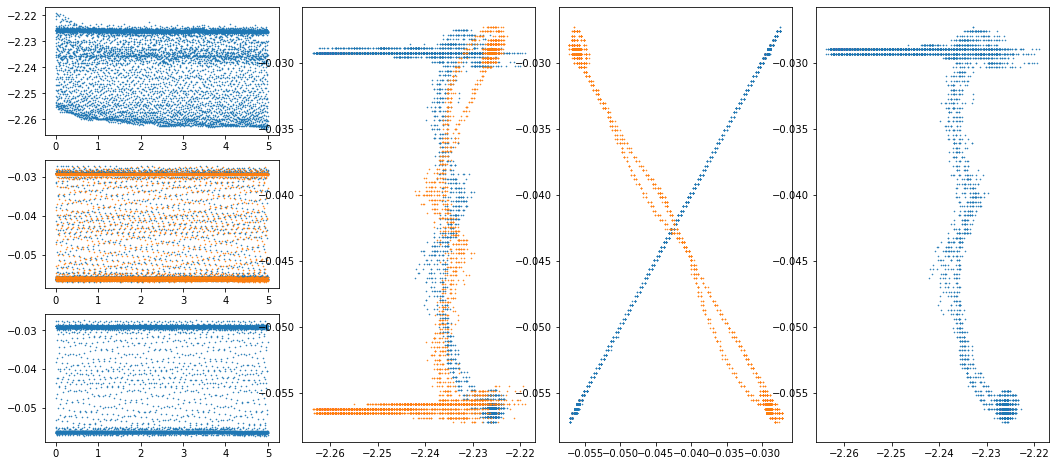

In [57]:
fig = plt.figure(figsize=(18,8))
grid = gs.GridSpec(4,4,wspace=0.1,)

XY = plt.subplot(grid[0,1])
YZ = plt.subplot(grid[0,2])
XZ = plt.subplot(grid[0,3])

XT = plt.subplot(grid[1,:])
YT = plt.subplot(grid[2,:])
ZT = plt.subplot(grid[3,:])

XT.scatter(t0,ch1,s=0.3)
YT.scatter(t0,Ch2,s=0.3)
YT.scatter(t1,ch2,s=0.3)
ZT.scatter(t1,ch3,s=0.3)

XY.scatter(ch1,ch2,s=0.3)
XY.scatter(ch1,Ch2,s=0.3)
YZ.scatter(ch2,ch3,s=0.3)
YZ.scatter(Ch2,ch3,s=0.3)
XZ.scatter(ch1,ch3,s=0.3)

plot3D = fig.add_subplot(grid[0,0],projection='3d')

plt.show()

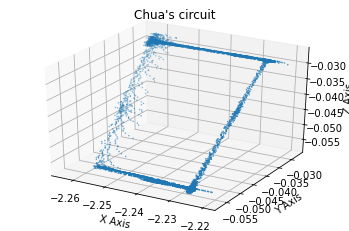

In [58]:
fig = plt.figure() 
ax = fig.add_subplot(projection='3d')

ax.scatter(*measurements[1:],s=0.3)
ax.set_xlabel("Channel 1")
ax.set_ylabel("Channel 2")
ax.set_zlabel("Channel 3")
ax.set_title("Chua's circuit")

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()